In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

Brain Tumor Mri - Akbank Dl Bootcamp Notebook
Brain Tumor MRI Classification — Adım Adım Notebook

Bu notebook, Akbank Derin Öğrenme Bootcamp proje dokümanındaki gereksinimlere (CNN tabanlı model, veri önişleme, augmentation, değerlendirme, Grad-CAM, hiperparametre denemeleri vb.) uygun şekilde, Brain Tumor MRI Dataset (Kaggle) kullanılarak hazırlanmıştır.

Hücre 1 — Proje tanımı 

Amaç: MR görüntülerinden beyin tümörü sınıflandırması yapmak (4 sınıf: glioma, meningioma, pituitary, no_tumor). Proje adımları: veri keşfi, önişleme & augmentation, CNN ve transfer-learning modelleri, değerlendirme (accuracy/loss/grafikler, confusion matrix, classification report), Grad-CAM ile görselleştirme, kısa hiperparametre araması.

Not: Bu notebook Kaggle ortamında çalıştırılmak üzere hazırlanmıştır. (Kaggle, GPU ve dataset erişimi sunar.)

In [8]:
# Eğer Kaggle üzerinde çalışıyorsanız bu hücreyi olduğu gibi çalıştırın.
# Gerekirse ek paket yüklemeleri (ör. keras-tuner) yapabilirsiniz.


# Paket yükleme (opsiyonel)
# !pip install -q -U keras-tuner


import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks


from sklearn.metrics import classification_report, confusion_matrix


print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


# Ayarlar
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [9]:
from pathlib import Path

kaggle_input = Path('/kaggle/input')

# otomatik arama: içinde 'brain' geçen bir klasör arıyoruz
candidates = [p for p in kaggle_input.iterdir() if 'brain' in p.name.lower()]

if len(candidates) > 0:
    data_root = candidates[0]   # <-- burası if bloğuna indentli
else:
    data_root = Path('/kaggle/input/brain-tumor-mri-dataset')  # <-- burası else bloğuna indentli

print('Kullanılan veri dizini:', data_root)
print('İçerik örneği:')
for p in sorted(list(data_root.glob('*')))[:20]:
    print('-', p.name)


Kullanılan veri dizini: /kaggle/input/brain-tumor-mri-dataset
İçerik örneği:
- Testing
- Training


Veri kümesini yükleme (image_dataset_from_directory) (code)

In [10]:
train_dir = None
val_dir = None
test_dir = None

if (data_root / 'Training').exists() and (data_root / 'Testing').exists():
    train_dir = data_root / 'Training'
    test_dir = data_root / 'Testing'

    # train içinden validation oluşturacağız
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset='training',
        seed=RANDOM_SEED
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset='validation',
        seed=RANDOM_SEED
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
else:
    # tek klasör içinde sınıf alt klasörleri varsa, buradan train/val/test ayıracağız
    dataset_dir = data_root
    image_paths = []
    labels = []
    class_names = [p.name for p in sorted(dataset_dir.iterdir()) if p.is_dir()]
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    
    for c in class_names:
        for ext in ('*.jpg','*.png','*.jpeg'):
            for p in (dataset_dir / c).glob(ext):
                image_paths.append(str(p))
                labels.append(class_to_idx[c])
    
    # shuffle and split
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, test_size=0.30, random_state=RANDOM_SEED, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
    )

    # create tf.data datasets from paths
    def paths_to_dataset(paths, labels, batch_size=BATCH_SIZE, shuffle=False):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        def _load(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, IMAGE_SIZE)
            img.set_shape((*IMAGE_SIZE,3))
            return img, label
        ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
        if shuffle:
            ds = ds.shuffle(1024, seed=RANDOM_SEED)
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds

    train_ds = paths_to_dataset(X_train, y_train, shuffle=True)
    val_ds = paths_to_dataset(X_val, y_val)
    test_ds = paths_to_dataset(X_test, y_test)

# show class names
class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else class_names
print('Sınıflar:', class_names)

# perform basic caching + prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']


Hücre 6 — Örnek görüntüler ve sınıf dağılımı görselleştirme 

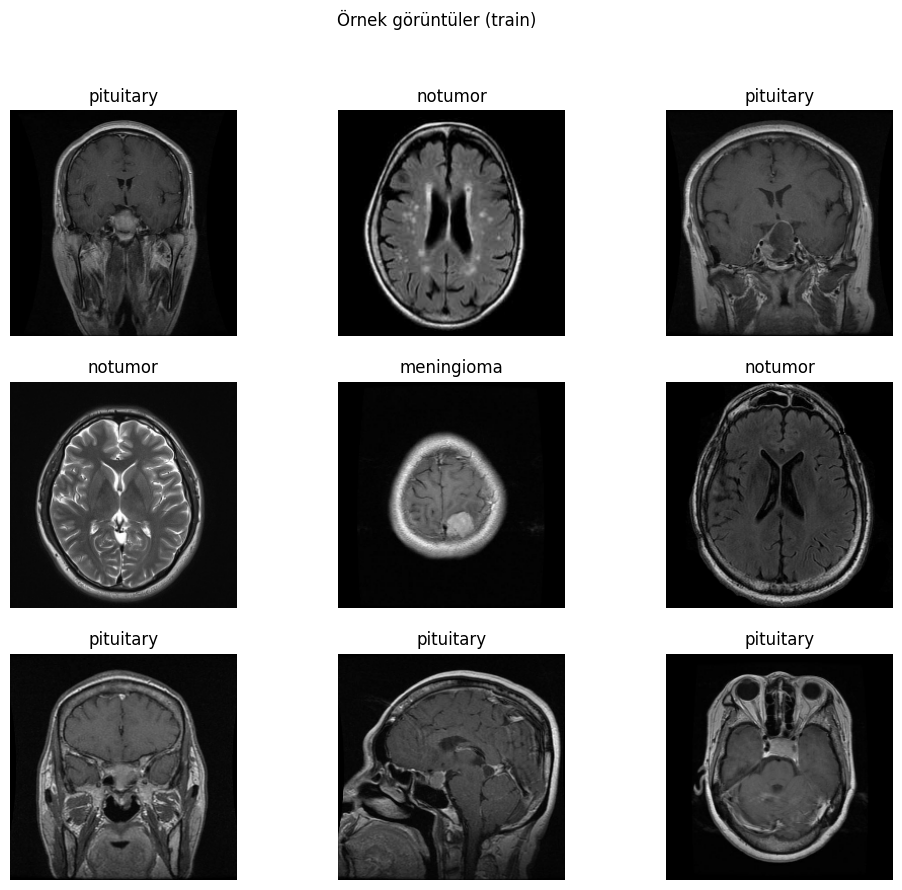

In [11]:
# Örnek resimler
plt.figure(figsize=(12,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.suptitle('Örnek görüntüler (train)')
plt.show()


# sınıf dağılımı (train için)
if hasattr(train_ds, 'class_names'):
    # image_dataset_from_directory kullanıldıysa klasörden say.
    counts = {}
    root_for_counts = train_dir if train_dir is not None else data_root
    for c in root_for_counts.iterdir():
        if c.is_dir():
            counts[c.name] = len(list(c.glob('*.jpg'))) + len(list(c.glob('*.png'))) + len(list(c.glob('*.jpeg')))
    pd.Series(counts).sort_values().plot(kind='barh', figsize=(8,5))
    plt.title('Sınıf dağılımı (tahmini)')
    plt.show()


Veri augmentasyonu (Keras preprocessing layers)

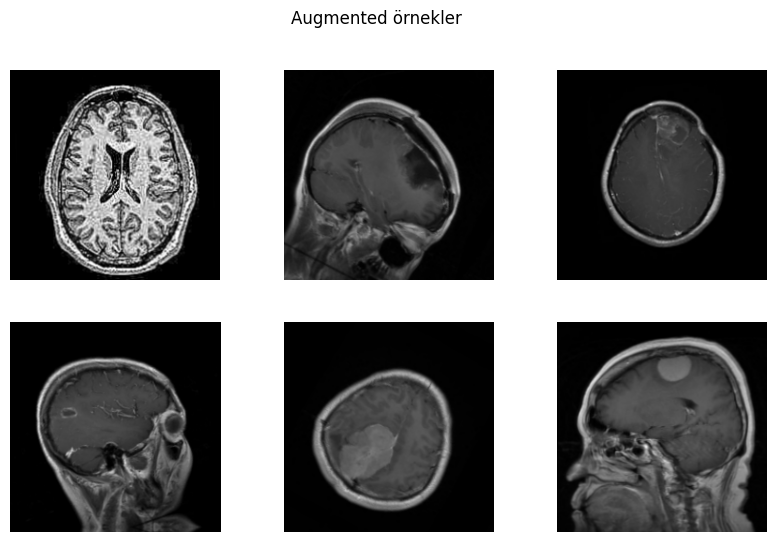

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Augmentation katmanı
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
], name='data_augmentation')

# Normalization katmanı
normalization_layer = layers.Rescaling(1./255)

# Örnek uygulama ve görselleştirme
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    
    plt.figure(figsize=(10,6))
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        plt.axis('off')
    plt.suptitle('Augmented örnekler')
    plt.show()



Basit CNN modeli

In [14]:
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Basit CNN modeli
def build_simple_cnn(input_shape=(*IMAGE_SIZE,3), n_classes=len(class_names)):
    inputs = layers.Input(shape=input_shape)
    x = normalization_layer(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Model oluştur
model = build_simple_cnn()
model.summary()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
chk = callbacks.ModelCheckpoint('simple_cnn_best.h5', save_best_only=True, monitor='val_loss')

# Eğitim
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,  # hızlı deneme için 12 epoch
    callbacks=[es, chk]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,276 (430.77 KB)

 Trainable params: 110,276 (430.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12


I0000 00:00:1758456393.090524     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.2578 - loss: 1.3715 - val_accuracy: 0.3047 - val_loss: 1.3039
Epoch 2/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2935 - loss: 1.3086 - val_accuracy: 0.4370 - val_loss: 1.1234
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4784 - loss: 1.1335 - val_accuracy: 0.4799 - val_loss: 1.0149
Epoch 4/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5492 - loss: 1.0521 - val_accuracy: 0.5061 - val_loss: 0.9847
Epoch 5/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5850 - loss: 1.0054 - val_accuracy: 0.5490 - val_loss: 0.9684
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5913 - loss: 0.9847 - val_accuracy: 0.5525 - val_loss: 0.9715
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6031 - loss: 0.9611 - val_accuracy: 0.5771 - val_loss: 0.9534
Epoch 8/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6076 - loss: 0.9508 - val_accuracy: 0.52

Transfer Learning

In [17]:
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess

def build_transfer_efficientnet(input_shape=(*IMAGE_SIZE,3), n_classes=len(class_names), train_base=False):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = ef_preprocess(x)  # EfficientNet'e uygun preprocessing
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = train_base
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Model oluştur
model_tf = build_transfer_efficientnet(train_base=False)

# Compile
model_tf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_tf.summary()

# Callbacks
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
chk2 = callbacks.ModelCheckpoint('effnet_b0_best.h5', save_best_only=True, monitor='val_loss')

# Eğitim
history_tf = model_tf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,  # hızlı deneme için
    callbacks=[es2, chk2]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/12


E0000 00:00:1758457158.682913      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.5674 - loss: 1.0452 - val_accuracy: 0.7522 - val_loss: 0.6081
Epoch 2/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7929 - loss: 0.5728 - val_accuracy: 0.7898 - val_loss: 0.5230
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8314 - loss: 0.4708 - val_accuracy: 0.8021 - val_loss: 0.4754
Epoch 4/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8464 - loss: 0.4247 - val_accuracy: 0.8126 - val_loss: 0.4448
Epoch 5/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.8473 - loss: 0.4021 - val_accuracy: 0.8161 - val_loss: 0.4479
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8638 - loss: 0.3725 - val_accuracy: 0.8371 - val_loss: 0.4163
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8638 - loss: 0.3646 - val_accuracy: 0.8345 - val_loss: 0.4201
Epoch 8/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8618 - loss: 0.3530 - val_accura